# Libaries

In [1]:
import numpy              as np
import pandas             as pd
import matplotlib.pyplot  as plt
import seaborn            as sns
import os
from mpl_toolkits.mplot3d import Axes3D

# Dataset

In [2]:
results_path = '../../LargeFilesResults'
posteriors   = pd.read_csv(os.path.join(results_path, 'betas_sharedprior.csv'))

In [4]:
fit_summary  = '../../LargeFilesResults/fit_summary_sharedprior.csv'
masses       = np.loadtxt(fit_summary, delimiter=',', usecols=[-1], skiprows=1, dtype=float)
redshifts    = np.loadtxt(fit_summary, delimiter=',', usecols=[-2], skiprows=1, dtype=float)
param_header = np.loadtxt(fit_summary, delimiter=',', dtype=str)[0,-2:]
fit_header   = pd.read_csv(os.path.join(results_path, 'entirefit_sharedpriors.csv'), nrows=1).columns

In [5]:
grid       = np.column_stack([redshifts, masses])
grid_split = np.array_split(grid, 5)
grid_split[0].shape

(900, 2)

# Output paths

In [6]:
figs_path = '../../Figs/FigsSharedPrior/'

In [7]:
dimensions = posteriors.columns.values.reshape(5,5)
rows       = dimensions[:,0].size
columns    = dimensions[0,:].size

In [8]:
whan_classes = ['Not classified', 'Retired/Passive', 'wAGN', 'sAGN', 'SF']
palette      = ['#e41a1c', '#ff7f00', '#4daf4a', '#377eb8','#984ea3']
figsize      = (20, 20)
alpha        = 0.4

/home/mlldantas/anaconda3/envs/py2k7/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


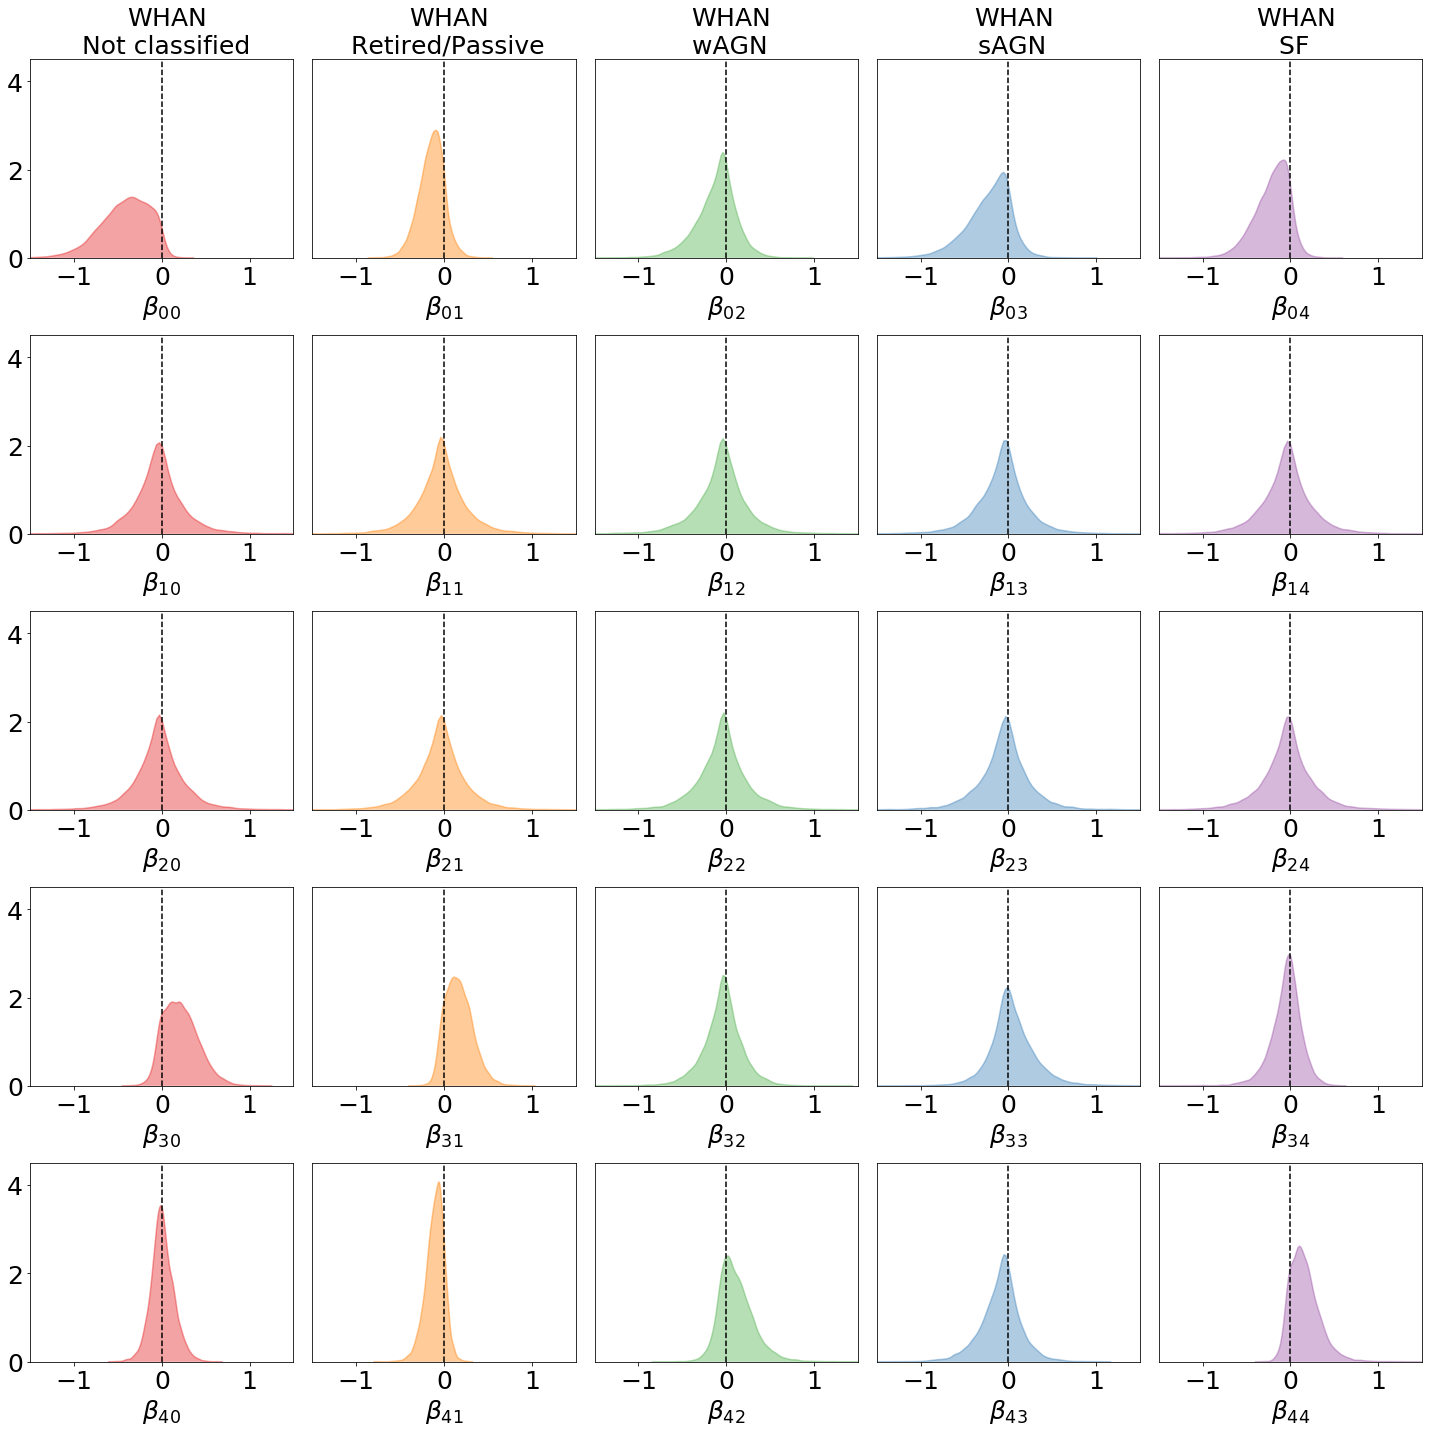

In [9]:
plt.subplots(figsize=figsize)
position = 0
for i in range(rows):
    for j in range(columns):
        position+=1
        plot = plt.subplot(rows, columns, position)
        posterior_temp = posteriors.columns.values.reshape(rows, columns)[i,j]
        sns.kdeplot(posteriors["%s" % posterior_temp].values, shade=True, alpha=alpha, color=palette[j])
        plt.axvline(x=0, linestyle="--", color='black')
        plt.tick_params('both', labelsize='25')
        plt.xlabel(r"$\beta_{%d%d}$" % (i,j), fontsize=25)
        plt.xlim([-1.5,1.5])
        plt.ylim([0,4.5])
        if (i==0):
            plt.title("$\,$ WHAN \n %s" % whan_classes[j], fontsize=25)
            if (j!=0): 
                plot.yaxis.set_visible(False)
            else: 
                plot.yaxis.set_visible(True)
        elif(i>=0)*(j==0): 
            plot.yaxis.set_visible(True)
        else: 
            plot.yaxis.set_visible(False)
plt.tight_layout()
plt.savefig(os.path.join(figs_path, "25betas.png"))
plt.savefig(os.path.join(figs_path, "25betas.pdf"))
plt.show()

## Separating data by probability (hence, by WHAN class)

In [ ]:
my_summary = []
output = []
for i in range(len(whan_classes)-4):
    j=i+1
    # reading each probability file and transposing it ---------------------------------------------------------------
    prob_temp    = pd.read_csv(os.path.join(results_path, 'sharedprior_prob0%d.csv' % (j)))
    prob_temp_tr = prob_temp.transpose()
    prob_temp_tr = prob_temp_tr[1:]
    lines_size   = prob_temp_tr.values[:,0].size
    cols_size    = prob_temp_tr.values[0,:].size
    
    # creating the first column --------------------------------------------------------------------------------------
    first_col = []
    for k in range(lines_size):
        first_col.append('prob0%d[%d]' % (j, k))
    first_col = pd.DataFrame(first_col)
    first_col.columns = ['probs']
    
    # setting the header ---------------------------------------------------------------------------------------------
    prob_header = []
    for l in range(cols_size):
        prob_header.append('iter0%d' % l)
    prob_temp_tr.columns = prob_header
    
    # adding the redshift and mass columns at the end of the data frame ----------------------------------------------
    prob_temp_tr.insert(loc=0, value=first_col.values, column='probs')
    prob_temp_tr.insert(loc=(len(prob_header)+1), value=grid_split[j][:,0], column='Z')
    prob_temp_tr.insert(loc=(len(prob_header)+2), value=grid_split[j][:,1], column='LOG_STELLAR_MASS')
    
    # creating a new data frame with the median, percentiles, etc. ---------------------------------------------------
    new_line_header = ['probs', 'median', 'mean', 'std', '2.5%', '25%', '50%', '75%', '97.5%']
    new_line = np.zeros_like(np.array(new_line_header))
    for each_prob in range(cols_size):
        all_iterations = prob_temp_tr.values[each_prob, 1:len(prob_header)]
        median = np.median(all_iterations)
        mean   = np.mean(all_iterations)
        std    = np.std(all_iterations)
        percentiles = np.percentile(a=all_iterations, q=[2.5, 25, 50, 75, 97.5], interpolation='nearest')
        new_stats = list(each_prob, median, mean, std, percentiles)
        new_line = np.row_stack(new_stats)
    new_bulk = pd.DataFrame(new_line[1:,:])
    new_bulk.columns = new_line_header
    new_bulk.to_csv(os.path.join(results_path, 'prob0%j_stats.csv'), header=True, )

In [ ]:
grid_split[0][:,0].size

In [ ]:
entire_fit.keys()[0:10]

In [ ]:
entire_fit.keys()[10:40]

In [ ]:
df01

In [ ]:
df01, df02, df03, df04, df05 = np.array_split(results, 5)

In [ ]:
parameter = df01['parameter'].astype(str)
redshifts = df01['Z'].astype(float)
masses    = df01['LOG_STELLAR_MASS'].astype(float)
mean      = df01['mean'].astype(float)
perc_2_5  = df01['2.5%'].astype(float)
perc_25   = df01['25%'].astype(float)
perc_50   = df01['50%'].astype(float)
perc_75   = df01['75%'].astype(float)
perc_97_5 = df01['97.5%'].astype(float)
sd        = df01['sd'].astype(float)

In [ ]:
idx_masses    = np.where(masses.values == 9.)
sub_redshifts = redshifts.values[idx_masses]
sub_mean      = mean.values[idx_masses]

In [ ]:
plt.plot(sub_redshifts, sub_mean[idx_mass],'.')
plt.show()

In [ ]:
plt.plot(df01["LOG_STELLAR_MASS"], mean,    '.', label="Probability", alpha=0.6)
plt.plot(df01["LOG_STELLAR_MASS"], perc_25, '.', label="25%",         alpha=0.6)
plt.plot(df01["LOG_STELLAR_MASS"], perc_75, '.', label="75%",         alpha=0.6)
plt.legend(loc='best')
plt.xlabel("Log M$_*$")
plt.ylabel("Prob")
plt.savefig('./Results/mass_temp.png')
plt.show()

In [ ]:
idx_z = np.where(redshifts.values==np.unique(redshifts)[0])

plt.plot(df01["LOG_STELLAR_MASS"].values[idx_z], mean.values[idx_z],    '.', label="Probability", alpha=0.6)
plt.plot(df01["LOG_STELLAR_MASS"].values[idx_z], perc_25.values[idx_z], '.', label="25%",         alpha=0.6)
plt.plot(df01["LOG_STELLAR_MASS"].values[idx_z], perc_75.values[idx_z], '.', label="75%",         alpha=0.6)
plt.legend(loc='best')
plt.xlabel("Log M$_*$")
plt.ylabel("Prob")
plt.savefig('./Results/mass_temp_onez.png')
plt.show()

In [ ]:
idx_mass01 = np.where((masses==np.unique(masses)[1]))
prob_mass01 = mean.values[idx_mass01]
print masses.values[idx_mass01]
print prob_mass01, np.unique(prob_mass01).size
print redshifts.values[idx_mass01], np.unique(redshifts.values[idx_mass01]).size

In [ ]:
print redshifts.values[idx_mass][0:4]
print mean.values[idx_mass][0:4]

In [ ]:
plt.plot(redshifts.values[idx_mass], mean.values[idx_mass], '.')
plt.show()

In [ ]:
%matplotlib notebook
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
# plt.scatter(redshift, sersic_gal, mean, c = '#feb24c', alpha=0.7)
ax.plot_trisurf(df01["Z"], df01["LOG_STELLAR_MASS"], df01["mean"], color='#a6611a', alpha=0.8, linewidth=0, antialiased=False)
ax.set_xlabel("\n z", fontsize=14)
ax.set_ylabel("\n Log M$_*$ (M$_\odot$)", fontsize=14)
ax.set_zlabel("\n Probability of \n UV upturn", fontsize=14)
for t in ax.yaxis.get_major_ticks(): 
    t.label.set_fontsize(10)
ax.set_yticks([9.75, 10.25, 10.75, 11.25, 11.75])
ax.view_init(elev=22., azim=315)
# ax.zaxis.set_rotate_label(False)
# plt.savefig('./../../Figs/logit3D_grid.pdf', dpi=100)

# for ii in xrange(180,360,10):
#     ax.view_init(elev=10., azim=ii)
#     plt.savefig("./Results/movie_short/movie_0%d_0.png" % ii)
    
# plt.savefig("./movie_0%d.png" % 359)

plt.show()

In [ ]:
# unique_z = matrix_unique_indices(df01["Z"].values, 'Z')

In [ ]:
# out = rearranging_other_features(new_matrix=unique_z, mean=mean, percentile02=perc_2_5, percentile25=perc_25, 
#                                  percentile50=perc_50, percentile75=perc_75, percentile97=perc_97_5, 
#                                  standard_deviation=sd, parameter_name="Z")

In [ ]:
# out

In [ ]:
np.unique(df01["Z"].values)

In [ ]:
np.unique(df01["mean"].values)

In [ ]:
idx = np.where(np.unique(df01["mean"].values))

In [ ]:
plt.plot(df01["Z"].values.astype(float)[idx], df01["mean"].values.astype(float)[idx], '.')
plt.show()